# <center> Coursera Capstone Project </center>

## <center> Where Should I move? </center>

![alt text][logo]

[logo]: https://i2.wp.com/movingtips.wpengine.com/wp-content/uploads/2019/02/moving-boxes-crosscountry.jpg "Picture from Moving.com"


### Introduction/Business Problem
The stakeholders in this case are my girlfriend and I. We have both recently graduated from college and have been debating where to live. We want to live somewhere near family, but also somewhere that is similar to our current situation. We live in Downtown Frederick at the moment and we really enjoy it. We have to move for her graduate program soon though and want to make the best decision on where to move.

With the knowledge that I've gained throughout these courses, I thought that it would be interesting to apply data science skills and the Foursquare location data to make a more informed decision. I have talked with her and she has helped me create a list of possible places that we could live. I want to perform a cluster analysis on these cities to see which of them tend to be like Downtown Frederick.

With the knowledge of which places are more similar to Frederick, we can make a more informed decision that will lead to greater satisfaction with our move. If there are others in a same situation, this mehtod may help you find similar living spaces.


### Data
This project requires that we use the Foursquare location data, which is perfect for the problem at hand. The Foursquare explore endpoint is of particular interest for this project. The explore endpoint allows for the user to specify where to search (latitude and longitude), how far around the given point to search (radius), how many venues to retreive (limit), and how to choose those top values (relevance, popularity, or distance). This call to the API will return the venues and information that meets all of those parameters. The venue information will include the location, category, and tips, among other things. Category is the main feature that we are interested in.

I hope to make a search for each of these cities on my list to obtain the top 100 most popular venues within a 5 kilometer radius of the center. I will then find the proportion of the categories for each city and use that as the feature set for the clustering algorithm. I will use K-means clustering to determine similar groups of cities based on their venues and then examine to see which group contains Frederick. Looking into that group will give me more information about what Frederick looks like and what similar cities tend to look like as well based on the venues that they have around.




## Let's begin the analysis process

After talking to my girlfriend we decided on a list of possibilities for living locations. Let's load these in and attach location coordinates to each. (Also let's load in some libraries that we will need!)



In [1]:
# Standard library for working with tables and data
import pandas as pd

# Standard library for working with arrays and numerical data
import numpy as np

# Library for creating visual maps
import folium

# Library for geocoding
from geopy.geocoders import Nominatim

# Library for working with requests to urls
import requests

# Libraries for working with json files
import json
from pandas.io.json import json_normalize

# Library to get the API credenials stored on my computer
import os

# Library for visualizations
import matplotlib.pyplot as plt

# Library for the K-means cluster algorithm used later
from sklearn.cluster import KMeans

In [2]:
# Load in the Possible Locations Table from the repository
df_url = 'https://raw.githubusercontent.com/BradenSmolko/Coursera_Capstone/master/PossibleLocations.csv'
locations_df = pd.read_csv(df_url)
locations_df.head()

,City,State
0,Frederick,MD
1,Annapolis,MD
2,Hagerstown,MD
3,Towson,MD
4,Hampden,MD


### Geocode possible locations
Use geopy to geocode the locations that we are considering for our move and make an initial map to visualize these locations.

In [3]:
# Use geopy's geocoder to acquire coordinates of cities

geolocator = Nominatim(user_agent = "capstone_project")
latitudes = []
longitudes = []

for city, state in zip(locations_df['City'], locations_df['State']):
    city_lat = None
    city_lng = None
    
    location = geolocator.geocode('{}, {}'.format(city, state))
    try:
        city_lat = location.latitude
        city_lng = location.longitude
    except:
        city_lat = None
        city_lat = None
        print('Error occured with {}, {}'.format(city, state))
        
    latitudes.append(city_lat)
    longitudes.append(city_lng)

In [4]:
# Add the coordinates to the locations_df
locations_df['Latitude'] = latitudes
locations_df['Longitude'] = longitudes

locations_df.head()

,City,State,Latitude,Longitude
0,Frederick,MD,39.414219,-77.410927
1,Annapolis,MD,38.978640,-76.492786
2,Hagerstown,MD,39.641922,-77.720264
3,Towson,MD,39.401855,-76.602388
4,Hampden,MD,39.330940,-76.634969


In [5]:
# Make a map object
my_map = folium.Map(location = [39.15, -77.0], zoom_start = 9.45, tiles = "Stamen Terrain")

# Add City markers to the map
for lat, lng, city, state in zip(locations_df['Latitude'], locations_df['Longitude'], locations_df['City'], locations_df['State']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#ADD8E6',
        fill_opacity=0.6,
        parse_html=False).add_to(my_map)

my_map

### Collect venue data and perform cluster analysis

Using the Foursquare API, let's collect venue data surrounding these different cities and use the categories of the venues for cluster analysis. This will give us an idea of which location options are similar and which group Frederick falls into.

In [6]:
# Let's get some information for our API calls

CLIENT_ID =  os.environ.get('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.environ.get('FOURSQUARE_CLIENT_SECRET')
VERSION = '20200901' 
LIMIT = 100 # Top 100 venues
RADIUS = 5000 # Within 5km radius of the coordinates

Now that we have the API key and varius request information saved, let's create a function to allow us to get the venue information (namely the categories) for each postal code. We will make a call to the Foursquare API for each postal code and extract the venue categories for each of the venues returned. The venue categories will be saved with the postal code and information so that we can cluster the postal codes based on the types of venues nearby.

In [7]:
def getNearbyVenues(cities, states, latitudes, longitudes):
    
    # Create an empty list to hold the venue categories and their respective city information
    venuesList = []
    
    # Loop through all of the cities to make requests about the venues surrounding each one
    for city, state, latitude, longitude in zip(cities, states, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&sortByPopularity=1'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            RADIUS, # 5000 meter raius
            LIMIT) # 100 venue limit (sorted by popularity)

        results = requests.get(url).json()
        
        venues_information = results['response']['groups'][0]['items']
        
        # For every venue of that given city's result set, store the category and city information
        for venue in venues_information:
            venuesList.append([city, state, latitude, longitude, venue['venue']['categories'][0]['name']])
            
        # Transform the list containing all of the venue categories and their corresponding cities into a DataFrame
        nearbyVenues = pd.DataFrame(venuesList)
        nearbyVenues.columns = ['City', 'State', 'Latitude', 'Longitude', 'Venue Category']
        
    return(nearbyVenues)

Using the function that we just created, let's get the venue data for each of the cities in our DataFrame.

In [8]:
nearby_venues_data = getNearbyVenues(locations_df['City'], locations_df['State'], locations_df['Latitude'], locations_df['Longitude'])
nearby_venues_data.head()

,City,State,Latitude,Longitude,Venue Category
0,Frederick,MD,39.414219,-77.410927,Shopping Mall
1,Frederick,MD,39.414219,-77.410927,Convenience Store
2,Frederick,MD,39.414219,-77.410927,Gas Station
3,Frederick,MD,39.414219,-77.410927,Grocery Store
4,Frederick,MD,39.414219,-77.410927,Warehouse Store


Now that we have the venue categories, let's make the data usuable for clustering analysis. 


To do this, we will one-hot encode the categories so that we can have a number 1 (yes) or 0 (no) to represent if a venue is related to that category.

In [9]:
cities_onehot = pd.get_dummies(nearby_venues_data[['Venue Category']], prefix="", prefix_sep="")

# Add City column back to dataframe
cities_onehot['City'] = nearby_venues_data['City'] 

# Move City column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,American Restaurant,Arcade,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Frederick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Frederick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Frederick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Frederick,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Frederick,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In order to get a single row of values to form a feature set for each city, we will group the rows by city and take the mean of each category. This will give us a single value to describe the category for each city. A higher number indicates that a larger percentage of the venues returned for that city belong to that category. 
(For example: a value of .5 for "Park" indicates that 50% of the venues returned by our search for that city were listed as airports)

In [10]:
cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped.head()

,City,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,American Restaurant,Arcade,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Alexandria,0.0,0.0,0.0,0.0,0.01,0.0,0.04,0.0,0.01,...,0.0,0.0,0.01,0.00,0.01,0.01,0.00,0.0,0.0,0.0
1,Annapolis,0.0,0.0,0.0,0.0,0.00,0.0,0.07,0.0,0.00,...,0.0,0.0,0.00,0.02,0.00,0.00,0.00,0.0,0.0,0.0
2,Arlington,0.0,0.0,0.0,0.0,0.00,0.0,0.04,0.0,0.00,...,0.0,0.0,0.01,0.00,0.01,0.00,0.00,0.0,0.0,0.0
3,Ashlar Hill,0.0,0.0,0.0,0.0,0.00,0.0,0.02,0.0,0.00,...,0.0,0.0,0.00,0.00,0.01,0.01,0.00,0.0,0.0,0.0
4,Bethesda,0.0,0.0,0.0,0.0,0.00,0.0,0.07,0.0,0.00,...,0.0,0.0,0.00,0.00,0.01,0.00,0.01,0.0,0.0,0.0


Now that we have our cities and their feature sets, let's run Kmean clustering to group the cities together based on the venue data. We're going to use the elbow method with multiple random states to find the optimal number of clusters for our analysis.

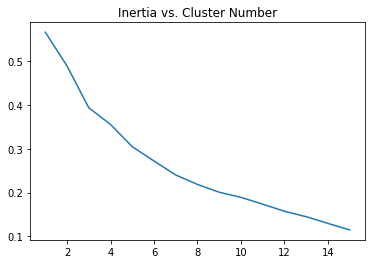

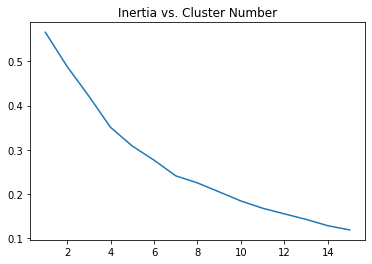

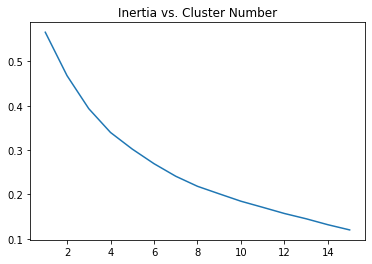

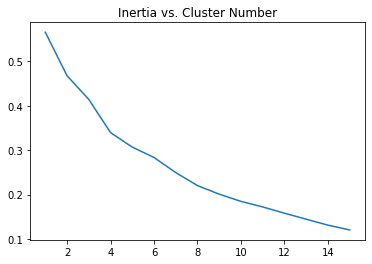

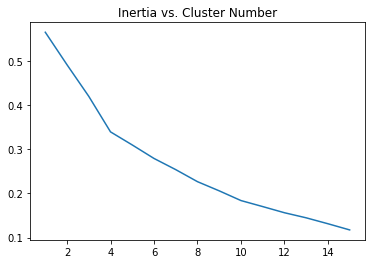

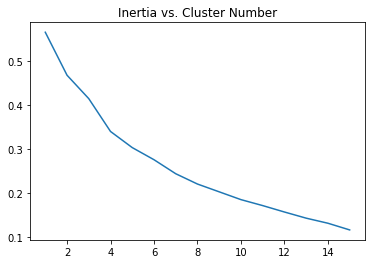

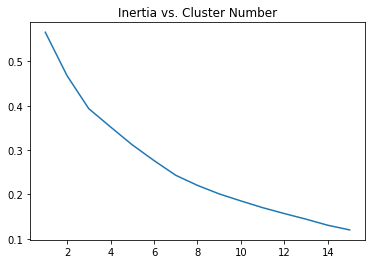

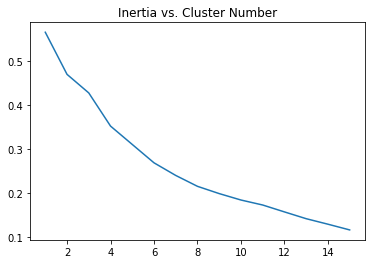

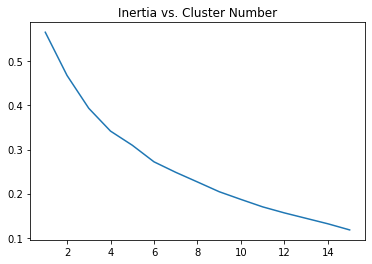

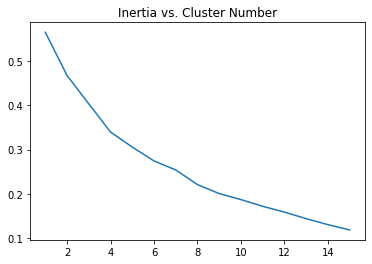

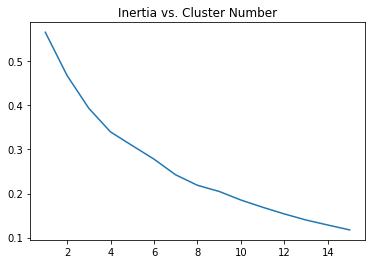

In [11]:
for seed in range(0,11):

    # Create a list to store the inertia values of each fit and a list for the cluster numbers
    clusters_x = []
    inertia_y = []

    # Run different numbers of clusters
    for n_cluster in range(1,16):

        # Set number of clusters
        kclusters = n_cluster

        cities_clusters = cities_grouped.drop('City', 1)

        # Run k-means clustering
        kmeans = KMeans(n_clusters=kclusters, init = 'k-means++', random_state = seed).fit(cities_clusters)

        # Append the inertia values and number of clusters to the empty lists
        clusters_x.append(n_cluster)
        inertia_y.append(kmeans.inertia_)

    # Plot the inertia values vs cluster number
    plt.plot(clusters_x, inertia_y)
    plt.title('Inertia vs. Cluster Number')
    plt.show()

Using the elbow method for multiple random seeds I was stuck between using 7, 8, or 10 clusters but, I'm going to settle on n=7 clusters for our analysis and random_state = 1 because the inertia values make a more clear elbow on this graph.

Now that we have the number of clusters determined, let's examine our labels.

In [12]:
# set number of clusters
kclusters = 7

city_clusters = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init = 'k-means++', random_state = 1).fit(city_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([1, 1, 2, 3, 3, 1, 3, 4, 1, 1, 1, 1, 4, 4, 1, 1, 1, 6, 4, 4, 0, 1,
       1, 3, 3, 5, 1, 1, 4, 2, 4])

Now that we have the labels, let's add them to our locations DataFrame.

In [13]:
cities_grouped['Cluster'] = kmeans.labels_

cities_grouped = cities_grouped[['City', 'Cluster']]

df_clusters = locations_df.join(cities_grouped.set_index('City'), on='City')
df_clusters.dropna(axis = 0, inplace = True)
df_clusters

,City,State,Latitude,Longitude,Cluster
0,Frederick,MD,39.414219,-77.410927,1
1,Annapolis,MD,38.978640,-76.492786,1
2,Hagerstown,MD,39.641922,-77.720264,4
3,Towson,MD,39.401855,-76.602388,3
4,Hampden,MD,39.330940,-76.634969,1
5,Parkville,MD,39.377329,-76.539687,4
6,Rockville,MD,39.084005,-77.152757,1
7,Bethesda,MD,38.981985,-77.124234,3
8,Chevy Chase,MD,38.982247,-77.088187,3
9,Glen Burnie,MD,39.162630,-76.625076,4


Now we have the clusters, great! Let's see them color-coded on the map.

In [14]:
# create map
map_clusters = folium.Map(location = [39.15, -77.0], zoom_start = 9.45, tiles = "Stamen Terrain")

# set color scheme for the clusters
colors = ['purple', 'green', 'red', 'orange', 'blue', 'brown', 'black']

# add markers to the map
for lat, lon, city, cluster in zip(df_clusters['Latitude'], df_clusters['Longitude'], df_clusters['City'], df_clusters['Cluster']):
    label = folium.Popup(str(city) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius = 5,
        popup = label,
        color = colors[int(cluster)],
        fill = True,
        fill_color = colors[int(cluster)],
        fill_opacity = 0.5).add_to(map_clusters)
       
map_clusters

### Explore the clusters

Now that we have all of the cities assigned to a cluster, let's explore what types of venues make these clusters similar/dissimilar.

To do this let's use the one-hot encoded DataFrame from before, add a cluster column, and determine the percentage of the venue categories in each cluster. We will join the cluster labels with the one-hot encoded dataframe containing all of the venues. When we group by cluster and take the mean of rows, the resulting number in each category column is the percentage of venues from that cluster that fall into that category.

In [15]:
# Join the onehot Dataframe with cluster labels
cluster_onehot = cities_onehot.join(cities_grouped.set_index('City'), on='City')

# Group by cluster and determine the percentages of the categories in each cluster
clusters_grouped = cluster_onehot.groupby('Cluster').mean().reset_index()
clusters_grouped

,Cluster,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Service,American Restaurant,Arcade,Art Gallery,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000728,0.001456,0.000,0.001456,0.000728,0.000000,0.045852,0.000728,0.001456,...,0.006550,0.003639,0.000728,0.002911,0.011645,0.002183,0.001456,0.000728,0.001456,0.001456
2,2,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,...,0.000000,0.000000,0.010000,0.005000,0.005000,0.000000,0.000000,0.005000,0.005000,0.010000
3,3,0.000000,0.000000,0.002,0.000000,0.000000,0.000000,0.038000,0.000000,0.000000,...,0.002000,0.002000,0.000000,0.000000,0.012000,0.004000,0.002000,0.000000,0.000000,0.000000
4,4,0.002857,0.000000,0.000,0.000000,0.000000,0.004286,0.028571,0.002857,0.000000,...,0.002857,0.010000,0.000000,0.001429,0.004286,0.007143,0.000000,0.000000,0.000000,0.000000
5,5,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
# Define a function to print the top 5 most popular categories for each cluster
def topFive(df):
    for cluster in df['Cluster']:
        temp_df = df
        temp_df = temp_df.loc[temp_df['Cluster'] == cluster, ]

        temp_df = pd.DataFrame(temp_df.drop('Cluster', 1).transpose())
        temp_df = temp_df.reset_index()
        temp_df.columns = ['Category', 'Percent of venues in cluster']
        temp_df['Percent of venues in cluster'] = temp_df['Percent of venues in cluster']*100
        sorted_df = temp_df.sort_values(by = 'Percent of venues in cluster', ascending = False).head(5)
        print('Cluster {}\'s Top Five Categories'.format(cluster))
        print(sorted_df.to_string(index = False))
        print('\n')

In [17]:
print('Frederick is in cluster {}\n\n'.format(df_clusters.at[0,'Cluster']))

topFive(clusters_grouped)

Frederick is in cluster 1


Cluster 0's Top Five Categories
         Category  Percent of venues in cluster
      Pizza Place                     16.666667
             Park                     16.666667
      Golf Course                     11.111111
   Sandwich Place                      5.555556
 Business Service                      5.555556


Cluster 1's Top Five Categories
            Category  Percent of venues in cluster
         Coffee Shop                      4.949054
 American Restaurant                      4.585153
       Grocery Store                      4.075691
                Park                      2.983988
         Pizza Place                      2.983988


Cluster 2's Top Five Categories
            Category  Percent of venues in cluster
                Park                          10.0
 Monument / Landmark                          10.0
               Hotel                           8.5
       Grocery Store                           7.0
         Coffee Shop   

It appears that the cities clustered with Frederick are quite varied in the venues that they have surrounding them. Where other clusters seem to have large percentages of specific categories represented in their venues, the Frederick cluster's most popular category accounts for less than 5% of the venues in the cluster. This tells me that the Frederick cluster is likely defined by having a variety of categories. This gives a lot of options to those living within 5km of the city center.

### Some more location analysis

Although venue similarity and access would be nice for the future, it's hard to justify moving to a location for the shops while we are still in the midst of a pandemic. This being said, if we want to find a place for more long term, the cluster that we just collected is great.

To make a choice for moving soon we want it to be a place that will also make us happy right now. One thing that has made this pandemic more enjoyable for us is going on hikes, so I would like to incorporate access to hiking as a key component of this analysis.

Let's find the number of parks or trails within a 25 mile radius of the different cities in the Frederick cluster.

In [24]:
frederick_cluster = df_clusters.loc[df_clusters['Cluster'] == df_clusters.at[0,'Cluster'], ].reset_index().drop('index', 1)
frederick_cluster

,City,State,Latitude,Longitude,Cluster
0,Frederick,MD,39.414219,-77.410927,1
1,Annapolis,MD,38.978640,-76.492786,1
2,Hampden,MD,39.330940,-76.634969,1
3,Rockville,MD,39.084005,-77.152757,1
4,Lutherville-Timonium,MD,39.421217,-76.626081,1
5,Columbia Town Center,MD,39.214397,-76.864589,1
6,Easton,MD,38.774495,-76.076307,1
7,Reston,VA,38.958374,-77.357980,1
8,Alexandria,VA,38.805110,-77.047023,1
9,Leesburg,VA,39.115450,-77.564545,1


In [19]:
# Create a list of category codes just to show
CATEGORY_CODES = [
    '4bf58dd8d48988d161941735', # Lake
    '52e81612bcbc57f1066b7a21', # National Park
    '4bf58dd8d48988d163941735', # Park
    '4eb1d4dd4b900d56c88a45fd', # River
    '5bae9231bedf3950379f89d0', # State/Provincial Park
    '4bf58dd8d48988d159941735'  # Trail
]

# Category codes as a string for search
CATEGORY_CODES = '4bf58dd8d48988d161941735,52e81612bcbc57f1066b7a21,4bf58dd8d48988d163941735,4eb1d4dd4b900d56c88a45fd,5bae9231bedf3950379f89d0,4bf58dd8d48988d159941735'


In [20]:
def getParksNearby(cities, states, latitudes, longitudes):
    # Create an empty list to hold the venue categories and their respective city information
    venuesList = []
    
    # Loop through all of the cities to make requests about the venues surrounding each one
    for city, state, latitude, longitude in zip(cities, states, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit=100'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            RADIUS, # 5km raius
            CATEGORY_CODES) # Types of venues to look for

        results = requests.get(url).json()
        
        venues_information = results['response']['venues']
        
        # For every venue of that given city's result set, store the category and city information
        for venue in venues_information:
            venuesList.append([city, state, latitude, longitude, venue['categories'][0]['name']])
            
        # Transform the list containing all of the venue categories and their corresponding cities into a DataFrame
        nearbyVenues = pd.DataFrame(venuesList)
        nearbyVenues.columns = ['City', 'State', 'Latitude', 'Longitude', 'Venue Category']
        
    return(nearbyVenues)

In [21]:
parks_nearby = getParksNearby(frederick_cluster['City'], frederick_cluster['State'], 
                              frederick_cluster['Latitude'], frederick_cluster['Longitude'])
parks_nearby

,City,State,Latitude,Longitude,Venue Category
0,Frederick,MD,39.414219,-77.410927,Park
1,Frederick,MD,39.414219,-77.410927,Park
2,Frederick,MD,39.414219,-77.410927,Trail
3,Frederick,MD,39.414219,-77.410927,Park
4,Frederick,MD,39.414219,-77.410927,Park
...,...,...,...,...,...
635,Fairfax,VA,38.846224,-77.306373,Park
636,Fairfax,VA,38.846224,-77.306373,Playground
637,Fairfax,VA,38.846224,-77.306373,Park
638,Fairfax,VA,38.846224,-77.306373,Trail


In [22]:
parks_nearby = parks_nearby

In [23]:
parks_nearby.groupby('City').count()['Venue Category']

City
Alexandria              50
Annapolis               49
Chantilly               38
Columbia Town Center    49
Easton                  20
Fairfax                 49
Frederick               46
Hampden                 50
Leesburg                48
Lutherville-Timonium    42
Reston                  49
Rockville               50
Tysons Corner           50
Vienna                  50
Name: Venue Category, dtype: int64

The limit for the API results is set at 50 by Foursquare, so this list doesn't show us much. Instead, let's use proximity to my girlfriend's graduate program and proximity to family to narrow down our pick.

The Luthiville-Timonium area is the closest to her school, but the Hampden area is still close and also is closer to family (also with a maxed out 50 count for parks) so when we move Hampden will be where we look!